In [61]:
import pandas as pd
import numpy as np
from statsmodels.stats.power import NormalIndPower
from statsmodels.stats.proportion import proportions_ztest
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [2]:
data = pd.read_csv(r'../data/cookie_cats.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [4]:
metrics_summary = data.groupby('version').agg({'userid':'count','retention_1':'sum', 'retention_7':'sum', 'sum_gamerounds':'sum'})

In [5]:
metrics_summary['retention_avg_1'] = metrics_summary['retention_1']/metrics_summary['userid']
metrics_summary['retention_avg_7'] = metrics_summary['retention_7']/metrics_summary['userid']
metrics_summary['sum_gamerounds_avg'] = metrics_summary['sum_gamerounds']/metrics_summary['userid']
metrics_summary

,userid,retention_1,retention_7,sum_gamerounds,retention_avg_1,retention_avg_7,sum_gamerounds_avg
version,,,,,,,
gate_30,44700,20034,8502,2344795,0.448188,0.190201,52.456264
gate_40,45489,20119,8279,2333530,0.442283,0.182000,51.298776


### retention_1 и retention_7

#### Проверка на достаточность данных для теста

In [6]:
group_sample_size = min(metrics_summary.loc['gate_30','userid'],metrics_summary.loc['gate_40','userid'])
p1_retention_1 = metrics_summary.loc['gate_30','retention_avg_1']    # Контрольная группа retention_1
p2_retention_1 = metrics_summary.loc['gate_40','retention_avg_1']    # Тестовая группа retention_1
effect_size_retention_1 = 0.0445                                     # Ожидаемое изменение retention_1 +10%

p1_retention_7 = metrics_summary.loc['gate_30','retention_avg_7']    # Контрольная группа retention_7
p2_retention_7 = metrics_summary.loc['gate_40','retention_avg_7']    # Тестовая группа retention_7
effect_size_retention_7 = 0.019                                      # Ожидаемое изменение retention_7 +10%

def sample_sufficiency_test(p1,p2,effect_size, group_sample_size):
    power_analysis = NormalIndPower()
    sample_size = power_analysis.solve_power(effect_size=effect_size, power=0.8, alpha=0.05, alternative='larger')

    print(f"Данных в каждой группе достаточно для теста - {group_sample_size>sample_size}")

##### retention_1

In [7]:
sample_sufficiency_test(p1_retention_1,p2_retention_1,effect_size_retention_1, group_sample_size)

Данных в каждой группе достаточно для теста - True


##### retention_7

In [8]:
sample_sufficiency_test(p1_retention_7,p2_retention_7,effect_size_retention_7, group_sample_size)

Данных в каждой группе достаточно для теста - True


#### Z-тест пропорций

##### retention_1

In [9]:
success = [metrics_summary.loc['gate_40','retention_1'], metrics_summary.loc['gate_30','retention_1']]
nobs = [metrics_summary.loc['gate_40','userid'], metrics_summary.loc['gate_30','userid']]

z_stat, p_value = proportions_ztest(count=success, nobs=nobs, alternative='larger')

print(f"Z-статистика: {z_stat:.3f}")
print(f"P-value: {p_value:.4f}")
print(f'Нулевая гипотеза отвергнута - {p_value < 0.05}')

Z-статистика: -1.784
P-value: 0.9628
Нулевая гипотеза отвергнута - False


##### retention_7

In [10]:
success = [metrics_summary.loc['gate_40','retention_7'], metrics_summary.loc['gate_30','retention_7']]
nobs = [metrics_summary.loc['gate_40','userid'], metrics_summary.loc['gate_30','userid']]

z_stat, p_value = proportions_ztest(count=success, nobs=nobs, alternative='larger')

print(f"Z-статистика: {z_stat:.3f}")
print(f"P-value: {p_value:.4f}")
print(f'Нулевая гипотеза отвергнута - {p_value < 0.05}')

Z-статистика: -3.164
P-value: 0.9992
Нулевая гипотеза отвергнута - False


### sum_gamerounds

#### EDA

In [38]:
data.groupby('version')['sum_gamerounds'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


In [57]:
q95 = data['sum_gamerounds'].quantile(0.95)

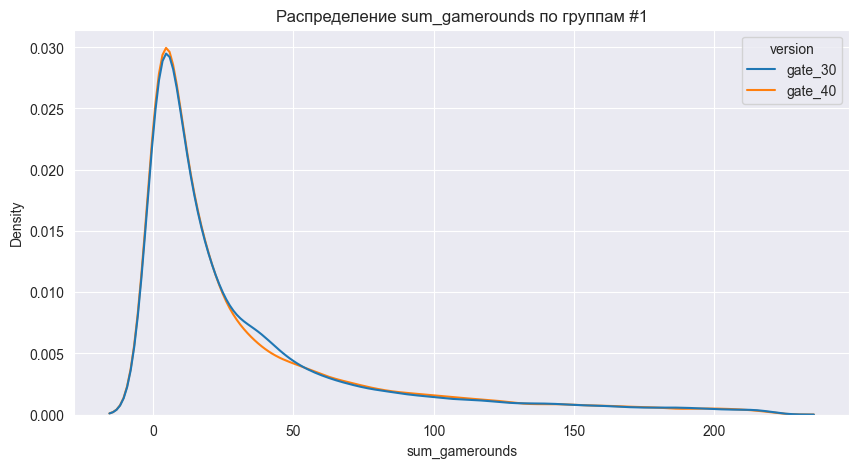

In [60]:
plt.figure(figsize=(10, 5))
sns.kdeplot(data=data[data['sum_gamerounds'] < q95], x='sum_gamerounds', hue='version', common_norm=False)
plt.title('Распределение sum_gamerounds по группам #1')
plt.grid(True)
plt.show()

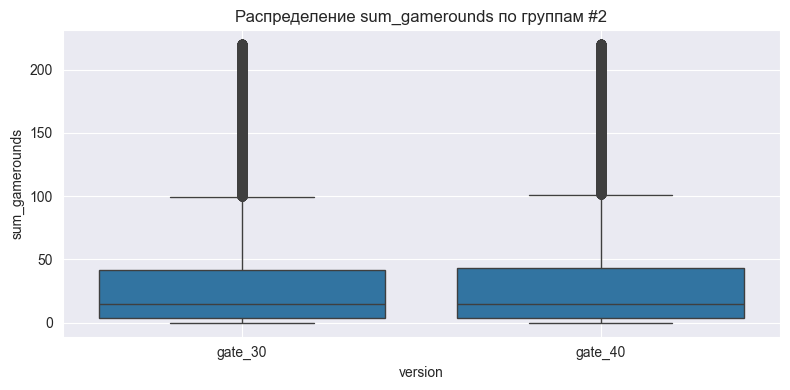

In [59]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=data[data['sum_gamerounds'] < q95], x='version', y='sum_gamerounds')
plt.title('Распределение sum_gamerounds по группам #2')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Mann–Whitney U‑тест

In [64]:
group_30 = data[data['version'] == 'gate_30']['sum_gamerounds']
group_40 = data[data['version'] == 'gate_40']['sum_gamerounds']

stat, p_value = mannwhitneyu(group_40, group_30, alternative='greater')

print(f"U-статистика: {stat}")
print(f"P-value: {p_value:.4f}")
print(f'Нулевая гипотеза отвергнута - {p_value < 0.05}')

U-статистика: 1009027049.5
P-value: 0.9749
Нулевая гипотеза отвергнута - False
